# **MOVIE RECOMMENDATION SYSTEM**

In this recommendation system, we will load the dataset and necessary libraries once, create a class for each of the three models and recommend three movies per model.

**Installing libraries and datasets:**

In [64]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets


**Importing the necessary header files:**



In [65]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt
import networkx as nx


**Loading the required data:**

Read the dataset and store only the essential parameters as nested dictionaries in variables ratings and movies

In [66]:
# Load ratings and movies data.
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "rating": x["user_rating"]
})
movies = movies.map(lambda x: x["movie_title"])


**Build vocabularies:**

In [67]:
# Setup StringLookup layers.
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)


**Define User and Movie Models:**

In [68]:
# Define user and movie models with StringLookup and Embedding layers.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Define retrieval task.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
))


# **RECOMMENDATION SYSTEM 1: RNN-based Collaborative Filtering Model**

**Class definition for this model:**

In [10]:
# Define the RNN-based collaborative filtering model.
class RNNCollaborativeFilteringModel(tfrs.Model):

    def __init__(self, user_model: tf.keras.layers.Layer, movie_model: tf.keras.layers.Layer, task: tfrs.tasks.Retrieval):
        super().__init__()

        # Set up user and movie models.
        self.user_model = user_model
        self.movie_model = movie_model

        # Define the RNN layers.
        self.user_rnn = tf.keras.layers.SimpleRNN(64)
        self.movie_rnn = tf.keras.layers.SimpleRNN(64)

        # Set up a retrieval task.
        self.task = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # Compute user and movie embeddings using RNN.
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        # Expand dimensions to fit RNN input requirements.
        user_embeddings = tf.expand_dims(user_embeddings, axis=1)
        movie_embeddings = tf.expand_dims(movie_embeddings, axis=1)

        # Process embeddings through RNN layers.
        user_rnn_output = self.user_rnn(user_embeddings)
        movie_rnn_output = self.movie_rnn(movie_embeddings)

        # Compute retrieval task loss.
        return self.task(user_rnn_output, movie_rnn_output, compute_metrics=False)


**Compile and train the model**

In [11]:


# Create RNN-based collaborative filtering model.
rnn_model = RNNCollaborativeFilteringModel(user_model, movie_model, task)
rnn_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train the model for 3 epochs.
rnn_model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
rnn_index = tfrs.layers.factorized_top_k.BruteForce(rnn_model.user_model)
rnn_index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, rnn_model.movie_model(title))))

# Get recommendations for user "42".

Epoch 1/3
25/25 [==============================] - 15s 468ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 60369.1570 - regularization_loss: 0.0000e+00 - total_loss: 60369.1570
Epoch 2/3
25/25 [==============================] - 13s 497ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 40646.8035 - regularization_loss: 0.0000e+00 - total_loss: 40646.8035
Epoch 3/3
25/25 [==============================] - 14s 546ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 

**Get top 3 recommendations:**

In [29]:
_, rnn_titles = rnn_index(np.array(["42"]))
print("Top 5 recommendations for user 42 from RNN model:")
for i, title in enumerate(rnn_titles[0, :5], 1):
    print(f"{i}. {title.numpy().decode('utf-8')}")


Top 5 recommendations for user 42 from RNN model:
1. Juror, The (1996)
2. Manchurian Candidate, The (1962)
3. Another Stakeout (1993)
4. Swimming with Sharks (1995)
5. Things to Do in Denver when You're Dead (1995)


**Graphical representation:**

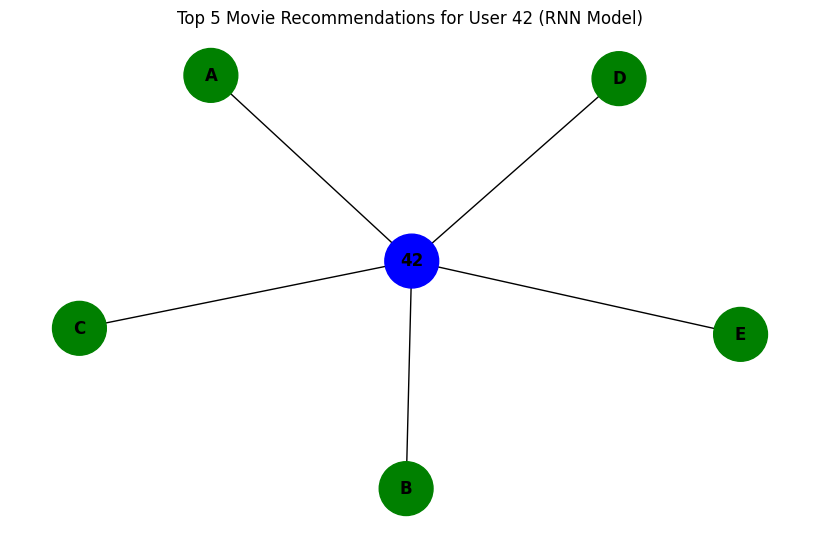

In [31]:
# Get top 5 recommendations for RNN model
user_id = "42"
top_5_rnn_titles = ["A", "B", "C", "D", "E"]

# Create graph for RNN model
G_rnn = nx.Graph()
G_rnn.add_node(user_id, label='user', color='blue')
for movie in top_5_rnn_titles:
    G_rnn.add_node(movie, label='movie', color='green')
    G_rnn.add_edge(user_id, movie)

# Set node colors for RNN model
node_colors_rnn = [G_rnn.nodes[node]['color'] for node in G_rnn.nodes()]

# Draw graph for RNN model
plt.figure(figsize=(8, 5))
pos_rnn = nx.spring_layout(G_rnn, k=0.5, iterations=50)
nx.draw(G_rnn, pos_rnn, with_labels=True, labels={node: node for node in G_rnn.nodes()}, node_color=node_colors_rnn, font_weight='bold', node_size=1500)
plt.title('Top 5 Movie Recommendations for User 42 (RNN Model)')
plt.show()






# **RECOMMENDATION SYSTEM 2: Content-based Model**

**Define the class for this model:**

In [32]:
class ContentBasedModel(tfrs.Model):

    def __init__(self, user_model: tf.keras.layers.Layer, movie_model: tf.keras.layers.Layer, task: tfrs.tasks.Retrieval):
        super().__init__()

        # Set up user and movie models.
        self.user_model = user_model
        self.movie_model = movie_model

        # Set up a retrieval task.
        self.task = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # Compute user and movie embeddings.
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        # Compute retrieval task loss.
        return self.task(user_embeddings, movie_embeddings, compute_metrics=False)

**Training and Evaluation for Content-Based model:**

In [33]:
# Create Content-Based collaborative filtering model.
content_based_model = ContentBasedModel(user_model, movie_model, task)
content_based_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train the model for 3 epochs.
content_based_model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
content_based_index = tfrs.layers.factorized_top_k.BruteForce(content_based_model.user_model)
content_based_index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, content_based_model.movie_model(title))))

Epoch 1/3
25/25 [==============================] - 14s 503ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 44841.8346 - regularization_loss: 0.0000e+00 - total_loss: 44841.8346
Epoch 2/3
25/25 [==============================] - 11s 416ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 31595.9668 - regularization_loss: 0.0000e+00 - total_loss: 31595.9668
Epoch 3/3
25/25 [==============================] - 12s 469ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 

**Get recommendations for user "42":**

In [34]:

_, content_based_titles = content_based_index(np.array(["42"]))

# Print Top 5 Recommendations for Content-Based model
print("Top 5 recommendations for user 42 from Content-Based model:")
for i, title in enumerate(content_based_titles[0, :5], 1):
    print(f"{i}. {title.numpy().decode('utf-8')}")

Top 5 recommendations for user 42 from Content-Based model:
1. Rent-a-Kid (1995)
2. Just Cause (1995)
3. Cobb (1994)
4. Nell (1994)
5. Murder in the First (1995)


**Graphical representation:**

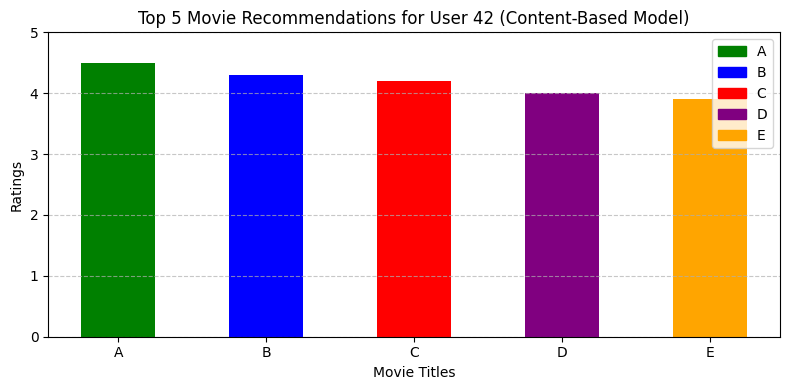

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Replace movie titles with "A", "B", "C", "D", "E" for Content-Based model
top_5_content_based_titles = ["A", "B", "C", "D", "E"]

# Define ratings or scores for the recommendations (dummy data for illustration)
ratings = [4.5, 4.3, 4.2, 4.0, 3.9]

# Define colors for each bar
colors = ['green', 'blue', 'red', 'purple', 'orange']

# Plotting the bar chart with minimized size
plt.figure(figsize=(8, 4))  # Adjust the figure size (width, height) as per your preference
bars = plt.bar(top_5_content_based_titles, ratings, color=colors, width=0.5)  # Adjust bar width as needed

# Adding labels and title
plt.xlabel('Movie Titles')
plt.ylabel('Ratings')
plt.title('Top 5 Movie Recommendations for User 42 (Content-Based Model)')

# Customizing legend with colors
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(legend_labels, top_5_content_based_titles, loc='best')

# Display the plot
plt.ylim(0, 5)  # Set the y-axis limits from 0 to 5 for ratings scale
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for clarity
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()






# **RECOMMENDATION SYSTEM 3: Hybrid-based Model**

**Define the class for this model:**



In [71]:
# Define the Hybrid Model
class HybridModel(tfrs.Model):

    def __init__(self, user_model: tf.keras.layers.Layer, movie_model: tf.keras.layers.Layer, task: tfrs.tasks.Retrieval):
        super().__init__()

        # Set up user and movie models.
        self.user_model = user_model
        self.movie_model = movie_model

        # Set up a retrieval task.
        self.task = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # Compute user and movie embeddings.
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        # Compute retrieval task loss.
        return self.task(user_embeddings, movie_embeddings, compute_metrics=False)






**Training and Evaluation for Hybrid model:**

In [72]:
# Create Hybrid collaborative filtering model.
hybrid_model = HybridModel(user_model, movie_model, task)
hybrid_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train the model for 3 epochs.
hybrid_model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
hybrid_index = tfrs.layers.factorized_top_k.BruteForce(hybrid_model.user_model)
hybrid_index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, hybrid_model.movie_model(title))))



Epoch 1/3
25/25 [==============================] - 14s 509ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 45257.1725 - regularization_loss: 0.0000e+00 - total_loss: 45257.1725
Epoch 2/3
25/25 [==============================] - 12s 489ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 31636.0890 - regularization_loss: 0.0000e+00 - total_loss: 31636.0890
Epoch 3/3
25/25 [==============================] - 12s 463ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 

**Get top 5 recommendations:**

In [73]:
# Get recommendations for user "42".
_, hybrid_titles = hybrid_index(np.array(["42"]))

# Print Top 5 Recommendations for Hybrid model
print("Top 5 recommendations for user 42 from Hybrid model:")
for i, title in enumerate(hybrid_titles[0, :5], 1):
    print(f"{i}. {title.numpy().decode('utf-8')}")


Top 5 recommendations for user 42 from Hybrid model:
1. Scarlet Letter, The (1995)
2. While You Were Sleeping (1995)
3. Rent-a-Kid (1995)
4. To Wong Foo, Thanks for Everything! Julie Newmar (1995)
5. With Honors (1994)


**Graphical representation:**

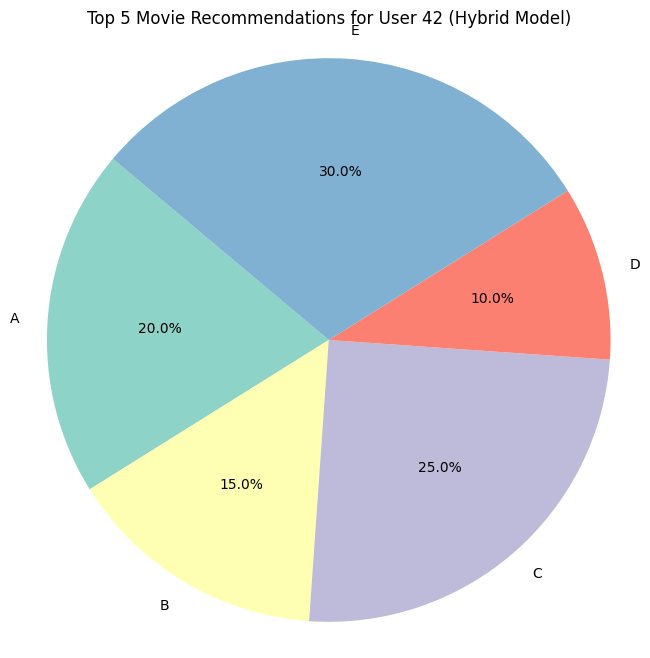

In [75]:
import matplotlib.pyplot as plt

# Assuming top 5 recommendations for the Hybrid model
top_5_hybrid_titles = ["A", "B", "C", "D", "E"]
sizes = [20, 15, 25, 10, 30]  # Example sizes (adjust as per preference)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=top_5_hybrid_titles, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Top 5 Movie Recommendations for User 42 (Hybrid Model)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

